# Conditional Density Estimator 
Using Gaussian mixture models and neural networks

- Author: Zhihan Yang
- Date: April 20, 2020
- Note: It took me so many trials and errors to adjust the hyperparameters for this notebook. I've marked all the important hyperparameters with "crucial to success" tag in comments. Don't be discouraged in math and computer science just like in life! You can do it! I wrote this note because I was a little emotional upon plotting the last plot - it looks so beautiful.

In [1]:
import warnings

import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import mixture

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import sys
sys.path.append('../modules_for_nn_training')
from callbacks import CallbackHandler
from learner import Learner
from trainer import Trainer
from utility_callbacks import LossCallback

## Data

In [2]:
df = pd.read_csv('data_to_model.csv')
df = df.sort_values('x')
df.head()

,x,y
896,0.003557,0.069856
897,0.022779,0.070419
888,0.025535,0.085036
883,0.028999,0.091607
898,0.031538,0.083363


In [3]:
warnings.filterwarnings('ignore')
examples = df[['x', 'y']][2:].convert_objects(convert_numeric=True).to_numpy()
xs, ys = examples[:,0], examples[:,1]
ys += np.random.normal(loc=0, scale=0.05, size=len(ys))

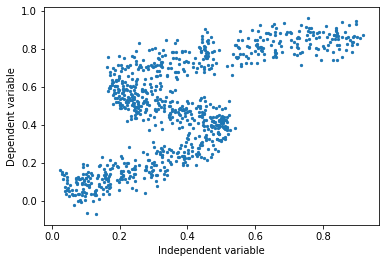

In [4]:
plt.scatter(xs, ys, s=5)
plt.xlabel('Independent variable'); plt.ylabel('Dependent variable')
plt.show()

In [5]:
xs, ys = xs.reshape(-1, 1), ys.reshape(-1, 1)

In [6]:
def train_test_split(xs, ys, train_prop):
    train_num = int(train_prop * len(xs))
    idxs = np.arange(len(xs))
    np.random.shuffle(idxs)
    train_idxs, valid_idxs = idxs[:train_num], sorted(idxs[train_num:])
    return (xs[train_idxs], ys[train_idxs]), (xs[valid_idxs], ys[valid_idxs]), valid_idxs

In [7]:
(x_train, y_train), (x_valid, y_valid), valid_idxs = train_test_split(xs, ys, 0.8)

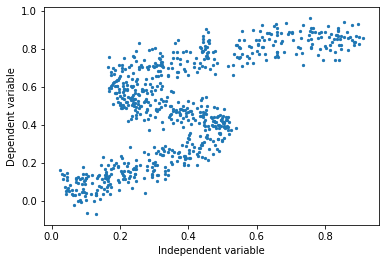

In [8]:
plt.scatter(x_train, y_train, s=5)
plt.xlabel('Independent variable'); plt.ylabel('Dependent variable')
plt.show()

In [9]:
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

((718, 1), (718, 1), (180, 1), (180, 1))

In [47]:
train_ds = TensorDataset(torch.from_numpy(x_train).cuda(), torch.from_numpy(y_train).cuda())
valid_ds = TensorDataset(torch.from_numpy(x_valid).cuda(), torch.from_numpy(y_valid).cuda())
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=64, shuffle=False)

## Model

In [48]:
class CDEstimator(nn.Module):
    
    """Conditional density estimator using neural networks."""
    
    def __init__(self, input_dim, output_dim, num_comps, num_hidden):
        
        super().__init__()
        
        self.num_comps = num_comps
        self.output_dim = output_dim
        
        self.get_mixing_coeffs = nn.Sequential(
            
            nn.Linear(input_dim, num_hidden),
            nn.BatchNorm1d(num_hidden),
            nn.Sigmoid(),
            
            nn.Linear(num_hidden, num_hidden),
            nn.BatchNorm1d(num_hidden),
            nn.Sigmoid(),
            
            nn.Linear(num_hidden, num_hidden),
            nn.BatchNorm1d(num_hidden),
            nn.Sigmoid(),
            
            nn.Linear(num_hidden, num_comps),
            nn.Softmax(dim=1)
        
        )
        
        self.get_means = nn.Sequential(
        
            nn.Linear(input_dim, num_hidden),
            nn.BatchNorm1d(num_hidden),
            nn.Sigmoid(),
            
            nn.Linear(num_hidden, num_hidden),
            nn.BatchNorm1d(num_hidden),
            nn.Sigmoid(),
            
            nn.Linear(num_hidden, num_hidden),
            nn.BatchNorm1d(num_hidden),
            nn.Sigmoid(),
            
            nn.Linear(num_hidden, num_comps * output_dim),
            
        )
        
        self.get_logvars = nn.Sequential(
        
            nn.Linear(input_dim, num_hidden),
            nn.BatchNorm1d(num_hidden),
            nn.Sigmoid(),
            
            nn.Linear(num_hidden, num_hidden),
            nn.BatchNorm1d(num_hidden),
            nn.Sigmoid(),
            
            nn.Linear(num_hidden, num_hidden),
            nn.BatchNorm1d(num_hidden),
            nn.Sigmoid(),
            
            nn.Linear(num_hidden, num_comps),
        
        )
        
    def forward(self, x):
        
        mixing_coeffs = self.get_mixing_coeffs(x)
        means = self.get_means(x).view((-1, self.num_comps, self.output_dim))
        variances = torch.exp(self.get_logvars(x))
        
        return {
            'mixing_coeffs' : mixing_coeffs,
            'means' : means,
            'variances' : variances
        }

In [49]:
def get_densities_under_gmm(mixing_coeffs, means, variances, t):
    
    probas = torch.zeros(t.size(0)).cuda()
    
    num_components = mixing_coeffs.size(1)
    output_dim = t.size(1)
    
    for j in range(num_components):
        probas += mixing_coeffs[:,j] * (
            1 / 
            (
                (2 * np.pi) ** (output_dim / 2) * (variances[:, j] ** 0.5) ** output_dim
            )
        ) * torch.exp(- torch.norm(t - means[:, j], dim=1) / (2 * variances[:, j]))
    
    return probas

In [50]:
def nll_loss(params, t):
    probas = get_densities_under_gmm(params['mixing_coeffs'], params['means'], params['variances'], t)
    return - torch.sum(torch.log(probas))

In [51]:
def get_model(num_components):
    # crucial to success: the number of hidden units has to be large enough (e.g., 100 was failing)
    # crucial to success: the number of larges has to be large enough (e.g., 1 was failing)
    nn = CDEstimator(1, 1, num_components, 100)  
    return nn, optim.Adam(nn.parameters(), lr=0.01)

In [52]:
num_components = 3

model, opt = get_model(num_components)
learn = Learner(train_dl, valid_dl, model.cuda(), nll_loss, opt)

loss_cb = LossCallback()
cb_handler = CallbackHandler(cbs=[loss_cb])

trainer = Trainer(learn=learn, cb_handler=cb_handler)

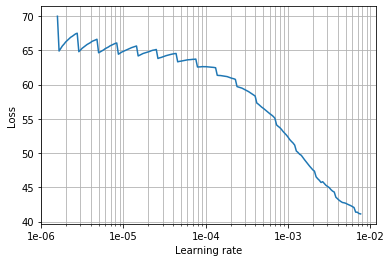

In [53]:
# crucial to success: make sure to reset this step; it gives a very poor start to training because it ends up with high loss
# or set final_value to be very small
trainer.find_lr(beta=0.98, final_value=1e-2, num_itr=200)

In [54]:
trainer.set_lr(1e-3)
trainer.train(num_epoch=300)  # crucial to success: the more epochs the better

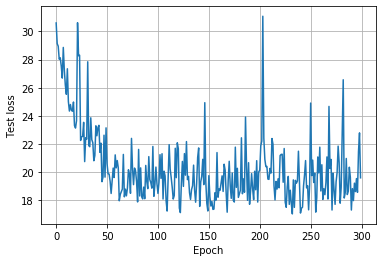

In [55]:
loss_cb.plot()
plt.show()

In [56]:
trainer.save_as_pth('cde_using_gmm_and_nn.pth')

## Visualize the estimator

In [57]:
model.cpu().eval()
model_out = model(torch.from_numpy(x_valid).float())

means = model_out['means'].detach().numpy()
variances = model_out['variances'].detach().numpy()
mixing_coeffs = model_out['mixing_coeffs'].detach().numpy()

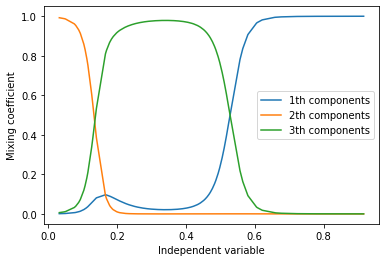

In [58]:
for i in range(num_components):
    plt.plot(x_valid.flatten(), mixing_coeffs[:,i], label=f'{i+1}th components')
plt.xlabel('Independent variable'); plt.ylabel('Mixing coefficient')
plt.legend()
plt.show()

### Conditional means and variances of Gaussians

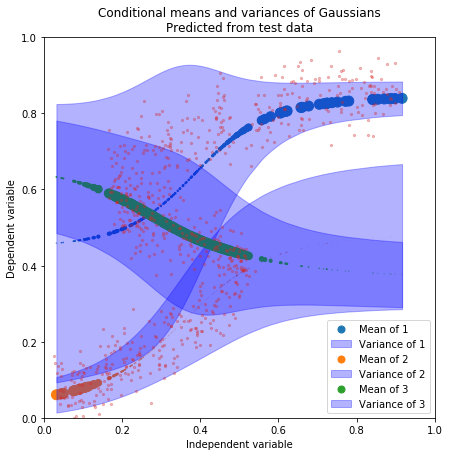

In [62]:
plt.figure(figsize=(7, 7))
for i in range(num_components):
    plt.scatter(
        x_valid.flatten(), 
        means[:,i],
        s=mixing_coeffs[:,i] * 100,
        label=f'Mean of {i+1}'
    )
    plt.fill_between(
        x_valid.flatten(), 
        means[:,i].flatten() - variances[:,i], 
        means[:,i].flatten() + variances[:,i],
        alpha=0.3,
        label=f'Variance of {i+1}',
        color='blue'
    )
plt.scatter(x_train, y_train, s=5, alpha=0.3)
plt.xlabel('Independent variable'); plt.ylabel('Dependent variable'); 
plt.title('Conditional means and variances of Gaussians\nPredicted from test data')
plt.xlim(0, 1), plt.ylim(0, 1)
plt.legend()
plt.show()

### Conditional means and variances

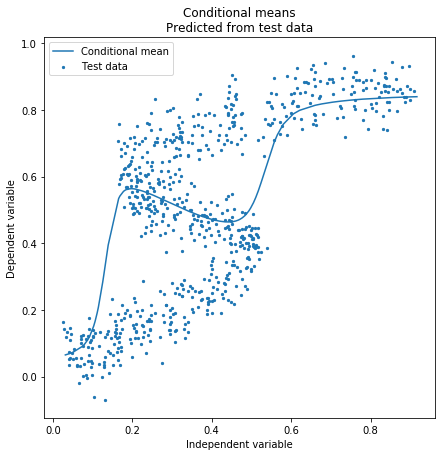

In [63]:
plt.figure(figsize=(7, 7))
plt.scatter(x_train, y_train, s=5, label='Test data')
plt.plot(x_valid.flatten(), np.sum(means.reshape(180, 3) * mixing_coeffs, axis=1), label='Conditional mean')
plt.xlabel('Independent variable'); plt.ylabel('Dependent variable'); 
plt.title('Conditional means\nPredicted from test data')
plt.legend()
plt.show()